# MN-interaction diagram

*MNclass* analyses the stresses and strains within a concrete section and enables to generate MN-interaction diagrams. Different material properties and sections can be incorporated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../libraries')
import rc
import sections as sect
import materials as mat
import utils

## Define materials

First, concrete and reinforcement material properties need to be defined.

### Concrete

Three ways to define concrete material properties are available. C50/60 concrete with characteristic cylinder strength of 50 MPa is analysed in this example.

In [2]:
fc = 50 # MPa
Ec = 30000 # MPa

#### Concrete equivalent stress block (esb1)

This model is defined using *esb1* material class. The strength of the material is generally reduced by a factor $\alpha$, recommended as 0.85. The depth of the equivalent stress block $\lambda$ is 0.8. The peak compressive strain $\epsilon_u$ is recommended as 0.0035.

![image](../assets/images/equivalent_stress_block.png)

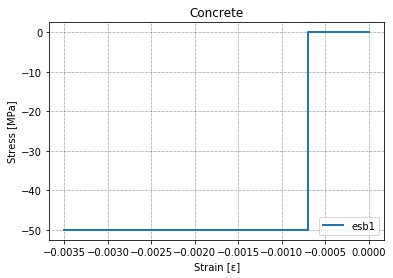

In [3]:
conMat = mat.esb1(ID = 'concrete EC2', fu = fc, epsilon_u = 0.0035, plotting=True, title="Concrete")
conMat.data_frame()

#### Concrete as elastic perfectly plastic material (stl1)

This model is defined using *stl1* material class.

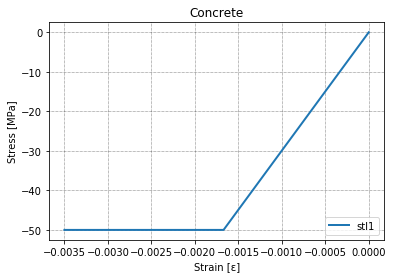

,ID,$$E_{1}[MPa]$$,$$E_{2}[MPa]$$,$$f_{y}[MPa]$$,$$f_{u}[MPa]$$,$$e_{y}$$,$$e_{u}$$,$$mu$$
concrete stl1,concrete stl1,30000,0.0,50,50,0.00167,0.0035,0.0


In [4]:
conMat = mat.stl1('concrete stl1', E1 = Ec, fy = fc, fu = fc, epsilon_u=0.0035,title="Concrete",plotting=True,tension=False)
conMat.data_frame()

#### Concrete as a trilinear curve model in compression and tensile stage given by a bilinear curve with softening (conMC2010)

This model is defined using *conMC2010* material class. Its properties are primarily derived from Model Code 2010.

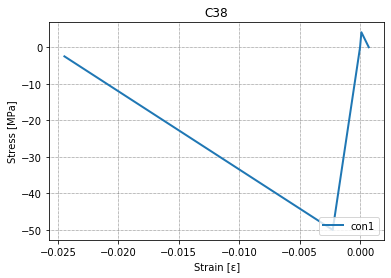

,ID,$$h[mm]$$,$$f_{c1}[MPa]$$,$$f_{c2}[MPa]$$,$$f_{t}[MPa]$$,$$E_{c0}[MPa]$$,$$E_{c1}[MPa]$$,$$E_{c2}[MPa]$$,$$E_{t1}[MPa]$$,$$E_{t2}[MPa]$$,$$G_{f}[N/mm]$$,$$G_{c}[N/mm]$$,$$e_{c1}$$,$$e_{c2}$$,$$e_{t1}$$,$$e_{t2}$$,$$alpha_{C}$$
C38,C38,50,50,2.5,4.1,36800,22100,-2100,36800,-6700,0.148,37.0,0.002264,0.024464,0.000111,0.000722,0.67


In [5]:
conMat = mat.conMC2010('C38', fc, 50, characteristic = False, plotting=True,title="C38")
conMat.data_frame()

### Concrete with quadratic and cubic overlays (stmdl)

This model is defined using *stmdl* material class. It requires to define the following properties:
* Ec1 - Secant compressive stiffness
* fc1 - Peak compressive strength
* Ec2 - Compressive softening stiffness
* fc2 - residual compressive strength
* Et1 - Secant tensile stiffness
* ft - Peak tensile strength
* Et2 - Tensile softening secant stiffness
* $\alpha_c$ - Compressive curve parameter, see below
* $\alpha_t$ - Tensile curve parameter, see below

$\alpha_c = [ 1, 1]$ and $\alpha_t = [ 1, 1]$. 

$|\alpha_c| \neq  0$ corresponds to a quadratic initial compressive branch, with $\alpha_c = \pm 1$ corresponding to a zero slope at $f_{c1}$.

$\alpha_c < 0$ corresponds to a cubic post-peak softening branch, with $\alpha_c = -1$ corresponsing to zero slopes at $f_{c1}$ and $f_{c2}$. 

$\alpha_t > 0$ corresponds to a quadratic initial tensile banch and a cubic post-peak softening branch, with $\alpha_t = 1$ corresponding to zero slopes at $f_{t}$. and the end of the softening branch. 

$\alpha_t < 0$ corresponds to a quadratic post-peak softening branch, with $\alpha_t = -1$ corresponding to a zero slopes at the end of this branch


![image](../assets/images/stmdl2.png)

The input parameters can be obtained using previously *conMC2010* material model instance with the code block shown below.

```
Ec1, fc1, Ec2, fc2, Et1, ft, Et2 = conMC2010_instance.adaptic_print()[2:]
alphac, alphat = -conMC2010_instance.alpha, conMC2010_instance.alpha
```

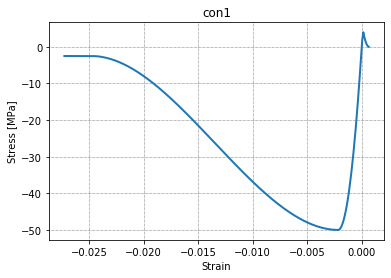

,$$ID$$,$$f_{c1}[MPa]$$,$$f_{c2}[MPa]$$,$$f_{t}[MPa]$$,$$E_{c0}[MPa]$$,$$E_{c1}[MPa]$$,$$E_{c2}[MPa]$$,$$E_{t1}[MPa]$$,$$E_{t2}[MPa]$$,$$e_{c1}$$,$$e_{c2}$$,$$e_{t1}$$,$$e_{t2}$$,$$alpha_{c}$$,$$alpha_{t}$$
stmdl2,stmdl2,-50.0,-2.5,4.5,46400,23200,-2100,38600,-8100,-0.002155,-0.024774,0.000117,0.000672,-1,-1


In [6]:
conMC2010_instance=mat.conMC2010('C50', fc, 50, plotting=False)
conMC2010_instance.data_frame()
Ec1, fc1, Ec2, fc2, Et1, ft, Et2 = conMC2010_instance.adaptic_print()[2:]
alphac, alphat = -1, -1
conMat=mat.stmdl2.from_ADAPTIC(Ec1, fc1, Ec2, fc2, Et1, ft, Et2,alphac,alphat)
conMat.basicCurve(plotting=True)
conMat.data_frame()

### Reinforcement

Reinforcement is defined using *stl1* class.

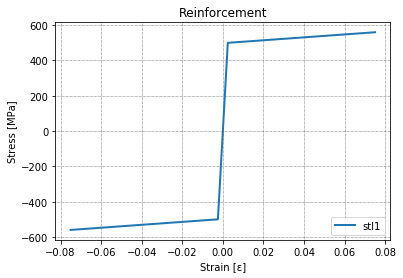

,ID,$$E_{1}[MPa]$$,$$E_{2}[MPa]$$,$$f_{y}[MPa]$$,$$f_{u}[MPa]$$,$$e_{y}$$,$$e_{u}$$,$$mu$$
reinforcement,reinforcement,205000,826.9,500,560,0.00244,0.075,0.0040337


In [7]:
reinfMat = mat.stl1('reinforcement', 205000, 500, 560, 0.075,title="Reinforcement",plotting=True,tension=True)
reinfMat.data_frame()

## Define sections

The sections can be defined as rectangular or T-sections. The reinforcement across the section width is unifrmly distributed across its width on the plots and is only informative.

### Rectagular section

This section can be defined using *rcrs* class.

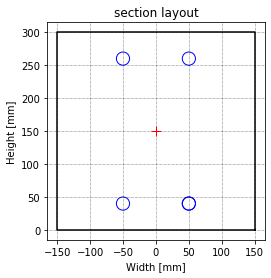

In [8]:
reinf_sect = [[2, 20, 40],[2,20,260]]
section=sect.rcrs(300,300,reinf_sect)
section.plotting(reverse=False)

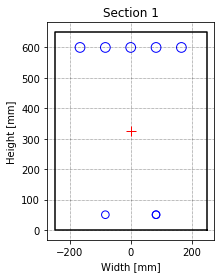

In [9]:
reinf_sect = [[5, 32, 600],[2,25,50]]
section=sect.rcrs(500,650,reinf_sect)
section.plotting(reverse=False,title='Section 1')

### T-section

This section can be defined using *rcts* class.

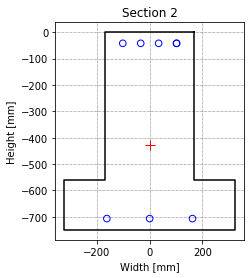

In [10]:
reinf_sect = [[3, 25, 707.5], [4, 25, 42.5]]
section=sect.rcts(190,560,650,340,reinf_sect)
section.plotting(reverse=True,title='Section 2')
# reverse=True plots the section upside down but it does not result in reversed section layout

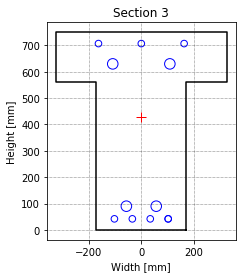

In [11]:
reinf_sect = [[3, 25, 707.5], [4, 25, 42.5], [2, 40, 90], [2, 40, 630]]
section=sect.rcts(190,560,650,340,reinf_sect)
section.plotting(reverse=False,title='Section 3')

## Strains and stresses within section

To show how the stresses and strains vary across the section, a few examples of stress distribution for concrete and steel materials are shown. This is based on the user choice of strains and/or the position of neutral axis. 

Positive moment indicates compression close to 0 x-coordinate and tension in the most furthest fibre on the x-axis.

In [12]:
MNclass=rc.MNclass(conMat,reinfMat,section)

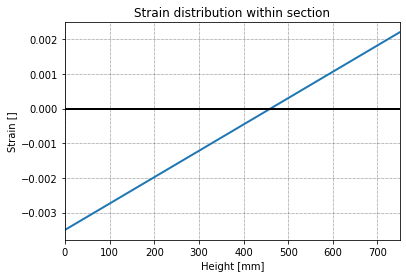

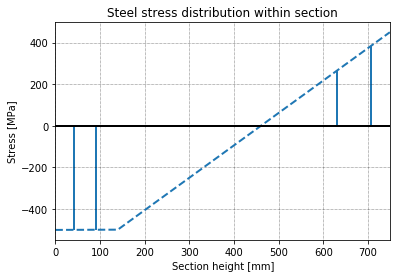

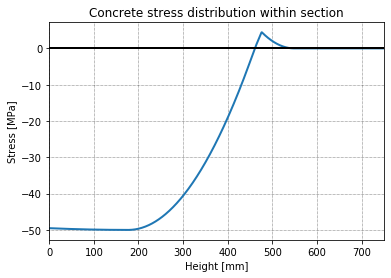

Total axial force: -7182 kN
Total moment: 2204 kNm


In [13]:
# In this example, the compressive strain at the top of the section (0.0 x-coordinate) is 0.0035 
# and tension at the bottom of the section on 0.002

f_tot,m_tot=MNclass.calc(eps0=-0.0035,epsH=0.0022, plotting=True,n_layers=800)

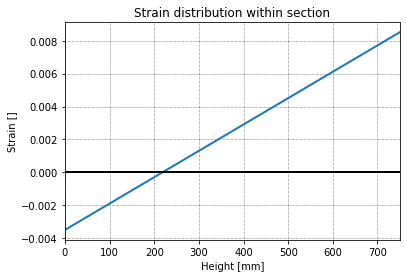

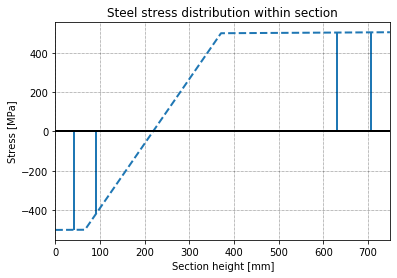

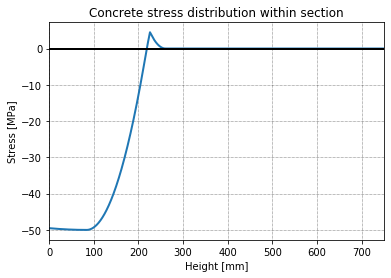

Total axial force: -2964 kN
Total moment: 2038 kNm


In [14]:
f_tot,m_tot=MNclass.calcX0(eps0=-0.0035,x_NA=218.5, plotting=True,n_layers=1000)

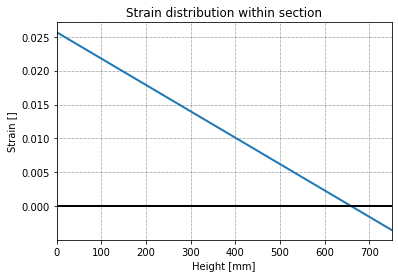

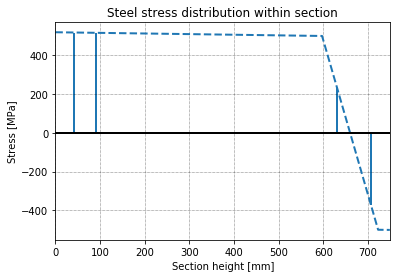

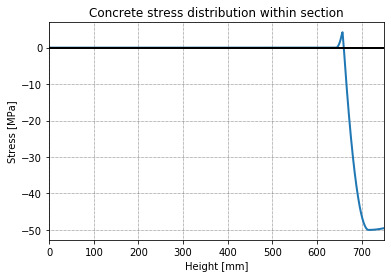

Total axial force: 76 kN
Total moment: -1512 kNm


In [15]:
f_tot,m_tot=MNclass.calcXH(epsH=-0.0035,x_NA=90, plotting=True,n_layers=800)

## MN cuve

M-N curve is plotted, within which boundaries the design bending moments should be maintained.

../libraries\utils.py:122: RuntimeWarning: invalid value encountered in greater_equal
  in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)
../libraries\utils.py:122: RuntimeWarning: invalid value encountered in less_equal
  in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)


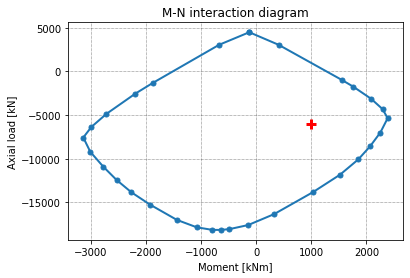

In [16]:
# Sagging moment (tension at height = 0) -ve for reverseMoment= False
# Sagging moment (tension at height = 0) +ve for reverseMoment= True

points=[[1000,-6000]] # Points=[[M1,F1],[M2,F2]]
reverseMoment=False
mnInteraction = MNclass.mnCurve(xRatio=[0.05,0.16,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.3,2,5,1E99],n_layers=100,epsU=-0.0035,reverseMoment=reverseMoment,points=points)

In [17]:
# Find exact moments at given axial load
axial = 0 # kN
find = utils.findExactPoint(np.array(mnInteraction).T,0,limY=False, multiple=True)
print('Exact moment at axial load axial {} kN are {} kNm and {} kNm'.format(axial,int(find[1][0]),int(find[1][1])))

Exact moment at axial load axial 0 kN are 1272 kNm and -1512 kNm


### Load MN-curve from csv file

Read csv file to load MN-curve. This could be used for comparison with other commercial software e.g. Response2000.

../libraries\utils.py:122: RuntimeWarning: invalid value encountered in greater_equal
  in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)
../libraries\utils.py:122: RuntimeWarning: invalid value encountered in less_equal
  in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)


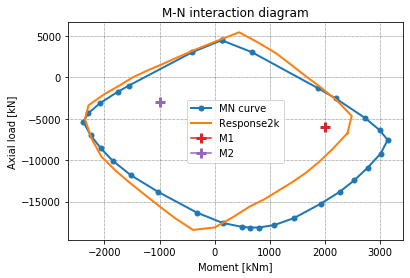

In [18]:
points=[[2000,-6000],[-1000,-3000]] # Points=[[M1,F1],[M2,F2]]
path = "../assets/Response2K/DFrame_fc50_full.csv"
reverseMoment=True
labels = ['MN curve','Response2k','M1','M2'] # if automatic use labels = None
mnInteraction = MNclass.mnCurve(xRatio=[0.05,0.16,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.3,2,5,1E99],n_layers=100,epsU=-0.0035,reverseMoment=reverseMoment,labels=labels,points=points,r2kPath=path,legend=True)